In [1]:
!pip install matplotlib  torch_geometric

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
from scipy.sparse import coo_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import NNConv, GCNConv

# Visualization
import matplotlib.pyplot as plt

# Import Data

In [3]:
# List of file paths
file_paths = [
    './ASPEDv1.1/5-24-Cadell-merged.csv',
    './ASPEDv1.1/6-1-Cadell-merged.csv',
    './ASPEDv1.1/6-7-Cadell-merged.csv',
    './ASPEDv1.1/6-21-Cadell-merged.csv',
    './ASPEDv1.1/6-28-Cadell-merged.csv'
]

def convert_datetime(column):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S', '%d-%m-%Y %H:%M', ...]  # List all expected formats

    for fmt in formats:
        try:
            return pd.to_datetime(column, format=fmt)
        except ValueError:
            continue
    return pd.to_datetime(column, errors='coerce')  # Fallback to coercion in case all formats fail

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['timestamp'] = convert_datetime(df['timestamp'])
    return df

dataframes = [load_data(file) for file in file_paths]
combined_data = pd.concat(dataframes, ignore_index=True)

In [4]:
# Import pedestrian data
#cadell524 = pd.read_csv("./ASPEDv1.1/5-24-Cadell-merged.csv")

# Dropping 1, 3, and 9m columns for simplicity.
del_cols = []
num_locations = 6

for loc in range(1, num_locations +1):
    for meter in ['1m', '3m', '9m']:
        del_cols.append(f'recorder{loc}_{meter}')

combined_data = combined_data.drop(del_cols, axis=1)

combined_data.columns = ["timestamp", "frame", "recorder1", "recorder2", "recorder3", "recorder4", "recorder5", "recorder6"]

# Filter out rows where time is not between 7 AM and 7 PM
# Ensure 'timestamp' is a datetime object
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])


combined_data.head()

,timestamp,frame,recorder1,recorder2,recorder3,recorder4,recorder5,recorder6
0,2023-05-24 11:33:00,0,0,1,0,0,0,0
1,2023-05-24 11:33:01,1,0,0,0,0,0,0
2,2023-05-24 11:33:02,2,0,0,0,0,0,0
3,2023-05-24 11:33:03,3,0,0,0,0,0,0
4,2023-05-24 11:33:04,4,0,0,0,0,0,0


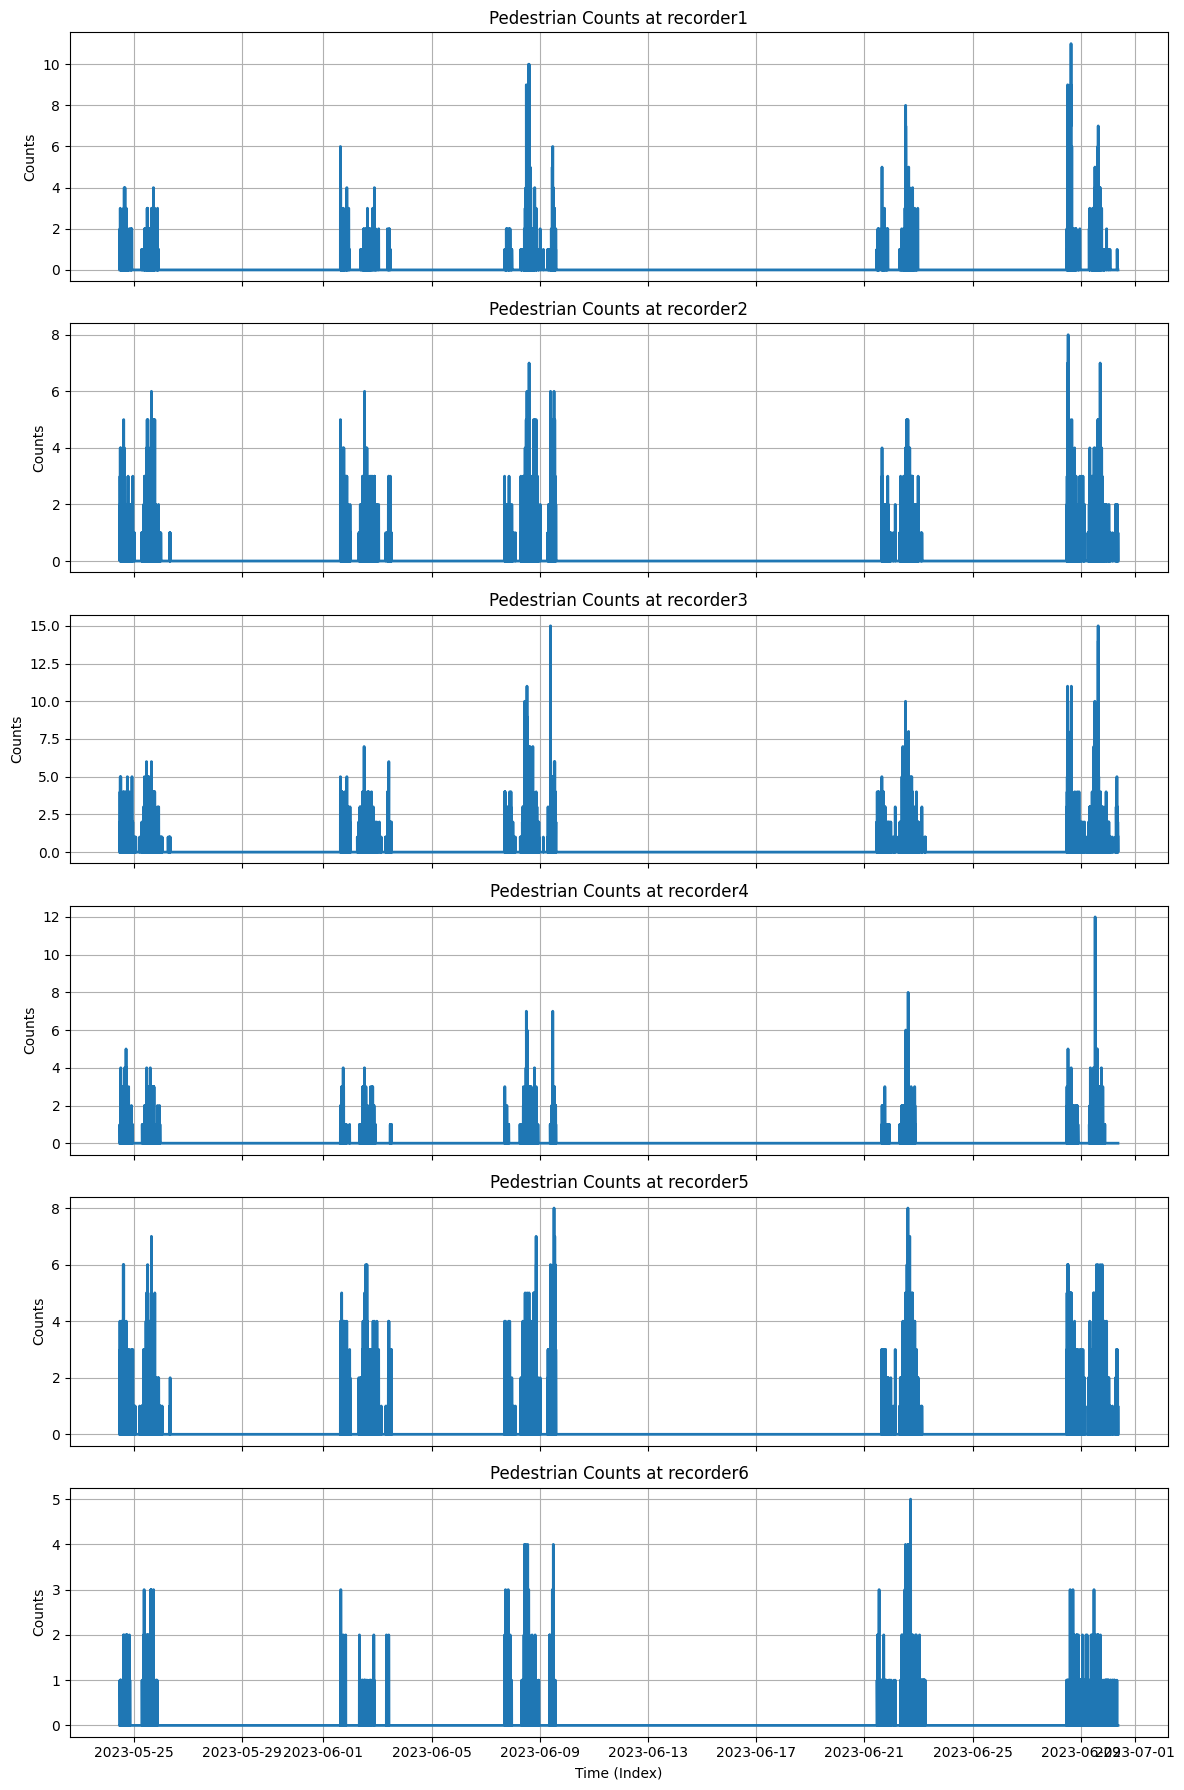

In [5]:
fig, axs = plt.subplots(6, 1, figsize=(12, 18), sharex=True)  # 6 plots, one below the other, sharing the x-axis

recorders = ['recorder1', 'recorder2', 'recorder3', 'recorder4', 'recorder5', 'recorder6']
for i, recorder in enumerate(recorders):
    axs[i].plot(combined_data['timestamp'], combined_data[recorder], label=f'{recorder}', linewidth=2)
    axs[i].set_title(f'Pedestrian Counts at {recorder}')
    axs[i].set_ylabel('Counts')
    axs[i].grid(True)

# Only set xlabel for the last subplot
axs[-1].set_xlabel('Time (Index)')

plt.tight_layout()
plt.show()


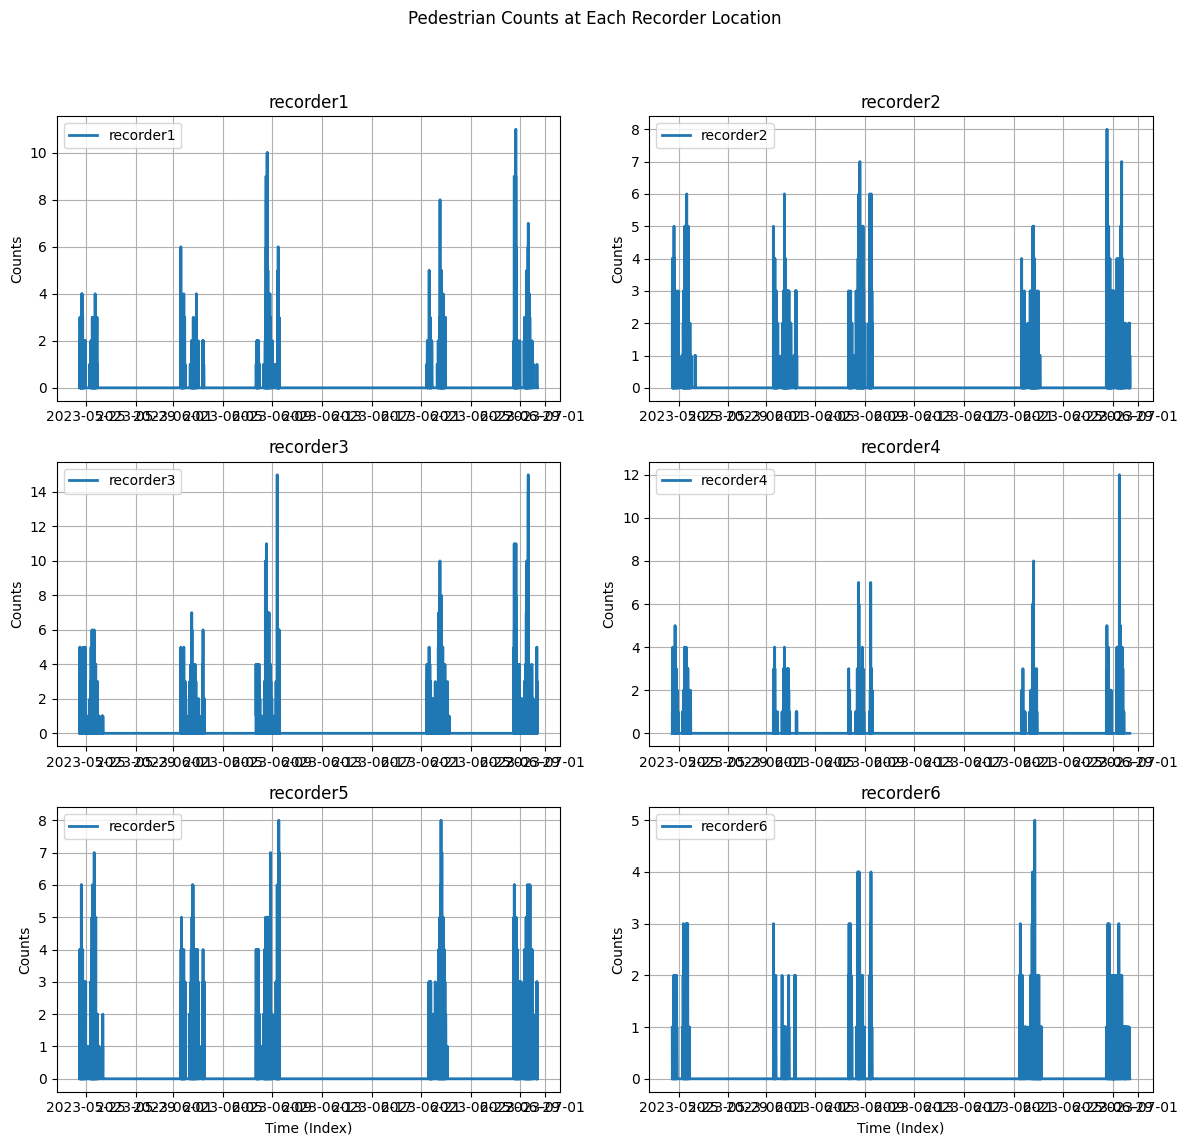

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))  # 3 rows, 2 columns
fig.suptitle('Pedestrian Counts at Each Recorder Location')

recorders = ['recorder1', 'recorder2', 'recorder3', 'recorder4', 'recorder5', 'recorder6']
for i, recorder in enumerate(recorders):
    # Calculate which row and column to place each subplot
    row = i // 2  # Integer division to determine row
    col = i % 2   # Modulus to determine column
    axs[row, col].plot(combined_data['timestamp'], combined_data[recorder], label=f'{recorder}', linewidth=2)
    axs[row, col].set_title(f'{recorder}')
    axs[row, col].set_ylabel('Counts')
    axs[row, col].grid(True)
    axs[row, col].legend()

# Setting x-labels for the bottom plots
axs[2, 0].set_xlabel('Time (Index)')
axs[2, 1].set_xlabel('Time (Index)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()

In [7]:
# Filtering out rows between 7 PM (19:00) to 7 AM (07:00)
combined_data = combined_data[
    (combined_data['timestamp'].dt.hour >= 7) & (combined_data['timestamp'].dt.hour < 19)
]

# Filter out if all recorders have 0 pedestrians
# Columns that contain the pedestrian counts for each recorder
recorder_columns = ['recorder1', 'recorder2', 'recorder3', 'recorder4', 'recorder5', 'recorder6']

# Filter out rows where all specified columns have zero values
# cadell524 = cadell524.loc[~(cadell524[recorder_columns] == 0).all(axis=1)]

print(combined_data.shape)

(378548, 8)


In [8]:
# Ensure the timestamp column is in datetime format
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])
combined_data['hour'] = combined_data['timestamp'].dt.hour
combined_data['day_of_week'] = combined_data['timestamp'].dt.dayofweek

combined_data.head()

,timestamp,frame,recorder1,recorder2,recorder3,recorder4,recorder5,recorder6,hour,day_of_week
0,2023-05-24 11:33:00,0,0,1,0,0,0,0,11,2
1,2023-05-24 11:33:01,1,0,0,0,0,0,0,11,2
2,2023-05-24 11:33:02,2,0,0,0,0,0,0,11,2
3,2023-05-24 11:33:03,3,0,0,0,0,0,0,11,2
4,2023-05-24 11:33:04,4,0,0,0,0,0,0,11,2


In [9]:
# 'timestamp' is the first column and the rest are recorder counts
timestamps = combined_data['timestamp']

# Selecting features for the model
feature_columns = ['hour', 'day_of_week'] 
recorder_columns = ['recorder1', 'recorder2', 'recorder3', 'recorder4', 'recorder5', 'recorder6']

# Create the feature (X) and target (Y) tensor
all_features = combined_data[recorder_columns + feature_columns]
target_features = combined_data[recorder_columns]

all_features_tensor = torch.tensor(all_features.values, dtype=torch.float)
target_tensor = torch.tensor(target_features.values, dtype=torch.float)

# Include Distance Information: Adjacency Matrix

In [10]:
# Step 2: Load the adjacency matrix
adjacency_path = './KlausCourtyard_AdjacencyMatrix.csv'
adjacency_data = pd.read_csv(adjacency_path)

adjacency_data.head()

,from,to,distance_m
0,recorder1,recorder1,0.00
1,recorder1,recorder2,14.30
2,recorder1,recorder3,13.75
3,recorder1,recorder4,28.50
4,recorder1,recorder5,26.00


In [11]:
recorder_to_index = {name: idx for idx, name in enumerate(combined_data.columns[2:8])}

# Create the edge index from the adjacency matrix
edge_index = adjacency_data.apply(
    lambda row: torch.tensor([recorder_to_index[row['from']], recorder_to_index[row['to']]], dtype=torch.long), 
    axis=1).tolist()
edge_index = torch.stack(edge_index).t().contiguous()


In [12]:
edge_index.shape

torch.Size([2, 36])

In [13]:
def gaussian_kernel(distance, sigma=1.0):
    """Apply Gaussian kernel to a given distance."""
    return np.exp(- (distance ** 2) / (2 * sigma ** 2))

sigma = adjacency_data['distance_m'].std()
adjacency_data['weight'] = gaussian_kernel(adjacency_data['distance_m'], sigma=sigma)

adjacency_data

,from,to,distance_m,weight
0,recorder1,recorder1,0.00,1.000000
1,recorder1,recorder2,14.30,0.563969
2,recorder1,recorder3,13.75,0.588873
3,recorder1,recorder4,28.50,0.102794
4,recorder1,recorder5,26.00,0.150558
5,recorder1,recorder6,22.80,0.233163
6,recorder2,recorder1,14.30,0.563969
7,recorder2,recorder2,0.00,1.000000
8,recorder2,recorder3,23.00,0.227257
9,recorder2,recorder4,17.50,0.424105


In [15]:
# Adjacency Matrix
# Include edge attributes (e.g., distance as edge weight)
edge_attr = torch.tensor(adjacency_data['weight'], dtype=torch.float).view(-1, 1)

edge_attr

tensor([[1.0000],
        [0.5640],
        [0.5889],
        [0.1028],
        [0.1506],
        [0.2332],
        [0.5640],
        [1.0000],
        [0.2273],
        [0.4241],
        [0.6726],
        [0.1358],
        [0.5889],
        [0.2273],
        [1.0000],
        [0.0126],
        [0.0392],
        [0.7725],
        [0.1028],
        [0.4241],
        [0.0126],
        [1.0000],
        [0.7169],
        [0.0045],
        [0.1506],
        [0.6726],
        [0.0392],
        [0.7169],
        [1.0000],
        [0.0240],
        [0.2332],
        [0.1358],
        [0.7725],
        [0.0045],
        [0.0240],
        [1.0000]])

# Data Preparation - Normalization and Train-Test Split

In [16]:
# Min-max scaling of features (pedestrian counts)
all_features_np = all_features_tensor.numpy()
target_np = target_tensor.numpy()

def min_max_scale(data):
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    return (data - data_min) / (data_max - data_min), data_min, data_max

scaled_features, features_min, features_max = min_max_scale(all_features_np)
scaled_targets, targets_min, targets_max = min_max_scale(target_np)

In [17]:
print("Min of features:", features_min)
print("Max of features:", features_max)
print("Min of targets:", targets_min)
print("Max of features:", targets_max)

Min of features: [0. 0. 0. 0. 0. 0. 7. 2.]
Max of features: [11.  8. 15. 12.  8.  5. 18.  5.]
Min of targets: [0. 0. 0. 0. 0. 0.]
Max of features: [11.  8. 15. 12.  8.  5.]


### Data Descriptive Table

In [18]:
scaled_targets_df = pd.DataFrame(scaled_targets, columns=recorder_columns) 

def reverse_min_max_scale(scaled_data, data_min, data_max):
    """Reverses the min-max scaling applied to the data."""
    return (scaled_data * (data_max - data_min)) + data_min

scaled_targets_df = reverse_min_max_scale(scaled_targets_df, targets_min, targets_max)

def compute_summary_statistics(df):
    
    summary_stats = pd.DataFrame({
        'Mean': df.mean(),
        'STD': df.std(),
        'Min': df.min(),
        'Max': df.max(),
        'Median': df.median(),
        'Range': df.max() - df.min()  # Range as max - min
    })
    return summary_stats

def compute_combined_statistics(df):
    # Flatten the DataFrame to a single Series of values for all recorders
    all_values = df.values.flatten()
    
    # Compute statistics
    mean = np.mean(all_values)
    std = np.std(all_values)
    minimum = np.min(all_values)
    maximum = np.max(all_values)
    median = np.median(all_values)
    data_range = maximum - minimum
    
    # Create a DataFrame for display
    summary_stats = pd.DataFrame({
        'Mean': [mean],
        'STD': [std],
        'Min': [minimum],
        'Max': [maximum],
        'Median': [median],
        'Range': [data_range]
    }, index=['All Recorders'])
    
    return summary_stats

# Compute summaries for features and targets
targets_summary = compute_summary_statistics(scaled_targets_df)
targets_combined_summary = compute_combined_statistics(scaled_targets_df)

print("\nTargets Summary:")
print(len(scaled_targets_df))

targets_summary
targets_combined_summary


Targets Summary:
378548


,Mean,STD,Min,Max,Median,Range
All Recorders,0.080195,0.376837,0.0,15.0,0.0,15.0


### Make Sequential Data for Time Series Prediction

In [19]:
# Define sequence length
sequence_length = 10  # For example, 10 time steps per sequence

def create_feature_sequences(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length)])
        
    return np.array(xs)

def create_target_sequences(data, seq_length):
    ys = []
    for i in range(len(data) - seq_length):
        ys.append(data[i + seq_length])  # Target is the next value after the sequence
    return np.array(ys)

# Assuming all_features_np and target_np contain the full sets of features and targets respectively
sequential_features = create_feature_sequences(scaled_features, 10)
sequential_targets = create_target_sequences(scaled_targets, 10)

# Convert to tensor
sequential_features_tensor = torch.tensor(sequential_features, dtype=torch.float)

# For predicting one step ahead
sequential_target_tensor = torch.tensor(sequential_targets, dtype=torch.float)  # Use the last point in each sequence as target

In [20]:
# Filter out sequences where all values are zero across all frames and features
valid_indices = [i for i, seq in enumerate(sequential_features) if not np.all(seq[:,:6] == 0)]

# Use valid_indices to filter both features and targets
filtered_features = sequential_features[valid_indices]
filtered_targets = sequential_targets[valid_indices]

In [21]:
filtered_features_tensor = torch.tensor(filtered_features, dtype=torch.float)
filtered_targets_tensor = torch.tensor(filtered_targets, dtype=torch.float)

# Display the first elements of each tensor
first_feature_sequence = filtered_features_tensor[5]  # First sequence of features
first_target = filtered_targets_tensor[5]  # First target

print("features example: \n", first_feature_sequence) 

print("target example: \n", first_target)

features example: 
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3636, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3636, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3636, 0.0000],
        [0.0909, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3636, 0.0000],
        [0.0909, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3636, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3636, 0.0000],
        [0.0000, 0.0000, 0.0667, 0.0000, 0.0000, 0.0000, 0.3636, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3636, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3636, 0.0000],
        [0.1818, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3636, 0.0000]])
target example: 
 tensor([0.0909, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


In [22]:
# Remove the last sequence from the feature tensor if its corresponding target does not exist
if len(sequential_features_tensor) > len(sequential_target_tensor):
    sequential_features_tensor = sequential_features_tensor[:-1]
    
print("Features tensor shape:", filtered_features_tensor.shape)
print("Target tensor shape:", filtered_targets_tensor.shape)

Features tensor shape: torch.Size([170281, 10, 8])
Target tensor shape: torch.Size([170281, 6])


In [23]:
filtered_features_df = pd.DataFrame(filtered_targets, columns=recorder_columns) 
filtered_features_df = reverse_min_max_scale(filtered_features_df, targets_min, targets_max)

# Compute summaries for features and targets
filtered_summary = compute_summary_statistics(filtered_features_df)
filtered_combined_summary = compute_combined_statistics(filtered_features_df)

print("\nFiltered Summary:")
print(len(filtered_features_df))

filtered_summary
filtered_combined_summary


Filtered Summary:
170281


,Mean,STD,Min,Max,Median,Range
All Recorders,0.173535,0.542744,0.0,15.0,0.0,15.0


# Splitting Dataset    

### Since the dataset has temporal dimension, I should not randomly shuffle. 

In [24]:
# Calculate the number of sequences in the dataset
num_sequences = len(filtered_features_tensor)

# Calculate the split index
split_index = int(num_sequences * 0.8)  # 80% of the data for training

# Split the features
train_features = filtered_features_tensor[:split_index]
test_features = filtered_features_tensor[split_index:]

# Split the targets
train_targets = filtered_targets_tensor[:split_index]
test_targets = filtered_targets_tensor[split_index:]

print(f"Training features shape: {train_features.shape}")
print(f"Training targets shape: {train_targets.shape}")
print(f"Testing features shape: {test_features.shape}")
print(f"Testing targets shape: {test_targets.shape}")

Training features shape: torch.Size([136224, 10, 8])
Training targets shape: torch.Size([136224, 6])
Testing features shape: torch.Size([34057, 10, 8])
Testing targets shape: torch.Size([34057, 6])


In [25]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch_geometric.data import Batch

class SequenceDataset(Dataset):
    def __init__(self, features, edge_index, edge_attr, targets):
        self.features = features
        self.targets = targets
        self.edge_index = edge_index
        self.edge_attr = edge_attr
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # Return features and targets, but edge_index is handled separately
        return self.features[idx], self.edge_index, self.edge_attr, self.targets[idx]

def collate_fn(batch):
    features, edge_index, edge_attr, targets = zip(*batch)

    features = torch.stack(features)
    targets = torch.stack(targets)
    
    # Since edge_index and edge_attr are assumed to be the same for all, just take the first one
    edge_index = edge_index[0]
    edge_attr = edge_attr[0]

    return features, edge_index, edge_attr, targets

# Creating dataset instances
# [Data(x=features_tensor[i], edge_index=edge_indices, y=target_tensor[i]) for i in range(len(features_tensor))]
train_dataset = SequenceDataset(train_features, edge_index, edge_attr, train_targets)
test_dataset = SequenceDataset(test_features, edge_index, edge_attr, test_targets)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)  # Typically you don't shuffle the test set

### Data Description Table

In [26]:
split_index

136224

In [27]:
train_targets_np = train_targets[:,:6].numpy()
test_targets_np = test_targets.numpy()

train_df = pd.DataFrame(train_targets_np, columns=recorder_columns)  
test_df = pd.DataFrame(test_targets_np, columns=recorder_columns)

train_df = reverse_min_max_scale(train_df, targets_min, targets_max)
test_df = reverse_min_max_scale(test_df, targets_min, targets_max)

# Compute summaries for features and targets
train_summary = compute_summary_statistics(train_df)
test_summary = compute_summary_statistics(test_df)

train_combined_summary = compute_combined_statistics(train_df)
test_combined_summary = compute_combined_statistics(test_df)

print("\nTrain Summary:")
print(train_summary)
print(train_df.shape)

print("\nTest Summary:")
print(test_summary)
print(test_df.shape)


Train Summary:
               Mean       STD  Min   Max  Median  Range
recorder1  0.161954  0.608557  0.0  10.0     0.0   10.0
recorder2  0.142581  0.452347  0.0   7.0     0.0    7.0
recorder3  0.332262  0.700000  0.0  15.0     0.0   15.0
recorder4  0.076741  0.330234  0.0   8.0     0.0    8.0
recorder5  0.167702  0.496065  0.0   8.0     0.0    8.0
recorder6  0.130263  0.372103  0.0   5.0     0.0    5.0
(136224, 6)

Test Summary:
               Mean       STD  Min   Max  Median  Range
recorder1  0.168306  0.822039  0.0  11.0     0.0   11.0
recorder2  0.144933  0.484085  0.0   8.0     0.0    8.0
recorder3  0.431424  0.931153  0.0  15.0     0.0   15.0
recorder4  0.113134  0.414001  0.0  12.0     0.0   12.0
recorder5  0.202279  0.575504  0.0   6.0     0.0    6.0
recorder6  0.099950  0.309478  0.0   3.0     0.0    3.0
(34057, 6)


# Define a GCN Model

In [28]:
class GCNLayer(nn.Module):
    def __init__(self, input_dim, output_dim, edge_feat_dim):
        super(GCNLayer, self).__init__()
        # Assuming NNConv or any other conv that supports edge attributes
        # First NNConv layer
        self.edge_nn1 = nn.Linear(edge_feat_dim, input_dim * output_dim)
        self.conv1 = NNConv(input_dim, output_dim, self.edge_nn1)
        
        # Second NNConv layer
        self.edge_nn2 = nn.Linear(edge_feat_dim, output_dim * output_dim)
        self.conv2 = NNConv(output_dim, output_dim, self.edge_nn2)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index, edge_attr):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.dropout(x)
        return x

class GCN_LSTM(nn.Module):
    def __init__(self, num_features, num_output, gcn_output_dim=16, hidden_dim=64, num_layers=2, edge_feat_dim=1):
        super(GCN_LSTM, self).__init__()
        ################################
        # GCN Layer outputs 16 features. 
        # hidden_dim should match the temporal complexity (the extent to which past information is needed to predict the future
        #                                                 seasonality and trends)
        ################################
        self.gcn = GCNLayer(num_features, gcn_output_dim, edge_feat_dim)
        # LSTM to process temporal sequences with two layers
        self.lstm = nn.LSTM(gcn_output_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_output)

    def forward(self, x, edge_index, edge_attr):
        ################################
        # How the input data is transformed as it passes through the model...
        # how the output of one layer feeds into the next
        ################################
        batch_size, sequence_length, num_features = x.size()
        
        # GCN processes node features individually.
        # Combine batch and sequence_length for GCN processing
        c_in = x.view(batch_size * sequence_length, num_features)  
        gcn_outputs = []

        for time_step in range(sequence_length):
            # Applies the GCN to the features of each time step independently, based on edge index
            gcn_out = self.gcn(c_in[time_step * batch_size:(time_step + 1) * batch_size], edge_index, edge_attr)
            
            # add a sequence dimension back, making it compatible for LSTM processing.
            gcn_outputs.append(gcn_out.unsqueeze(1))
        
        # Concatenates the list of outputs into a single tensor. 
        # This tensor now represents a batch of sequences where each sequence is the output from the GCN over time
        gcn_outputs = torch.cat(gcn_outputs, dim=1)  # [batch, sequence_length, gcn_out_features]
        lstm_out, _ = self.lstm(gcn_outputs)
        
        out = self.fc(lstm_out[:, -1, :])  # Use the last time step

        return out

In [33]:
model = GCN_LSTM(num_features=sequential_features_tensor.shape[2], num_output=sequential_target_tensor.shape[1], gcn_output_dim=16,
                hidden_dim=64, num_layers=2, edge_feat_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [34]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0

    for features, edge_index, edge_attr, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted y by passing x to the model
        outputs = model(features, edge_index, edge_attr)

        # Compute and print loss
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    average_loss = total_loss / len(train_loader)
    return average_loss

def run_training(model, train_loader, valid_loader=None, epochs=10):
    for epoch in range(epochs):
        avg_train_loss = train_model(model, train_loader, criterion, optimizer)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}')

        if valid_loader:
            avg_valid_loss = evaluate_model(model, valid_loader, criterion)
            print(f'Validation Loss: {avg_valid_loss:.4f}')

# Helper function to evaluate the model
def evaluate_model(model, loader, criterion, return_predictions=False):
    model.eval()
    total_loss = 0
    all_predictions = []
    with torch.no_grad():
        for features, edge_index, edge_attr, targets in loader:
            outputs = model(features, edge_index, edge_attr)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            if return_predictions:
                all_predictions.append(outputs)
    if return_predictions:
        return total_loss / len(loader), torch.cat(all_predictions, dim=0)
    return total_loss / len(loader)

def print_sample_data(loader):
    # Fetch the first batch
    for features, edge_index, edge_attr, targets in loader:
        # print("Sample Features:")
        # print(features)
        print("Sample Features Shape:", features.shape)
        print("Sample Edge Index:")
        print(edge_index)
        print("Sample Edge Index Shape:", edge_index.shape)
        # print("Sample Targets:")
        # print(targets)
        print("Sample Targets Shape:", targets.shape)
        
        # Break after the first batch to only print one sample batch
        break

# Example of how to call this function with the train_loader
# print_sample_data(train_loader)

In [35]:
print_sample_data(train_loader)

Sample Features Shape: torch.Size([32, 10, 8])
Sample Edge Index:
tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
         4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5],
        [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
         0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]])
Sample Edge Index Shape: torch.Size([2, 36])
Sample Targets Shape: torch.Size([32, 6])


In [36]:
# Actual Training
run_training(model, train_loader, test_loader, epochs=50)

# get predictions and loss
_, predictions = evaluate_model(model, test_loader, criterion, return_predictions=True)

Epoch [1/50], Loss: 0.0031
Validation Loss: 0.0038
Epoch [2/50], Loss: 0.0031
Validation Loss: 0.0037
Epoch [3/50], Loss: 0.0031
Validation Loss: 0.0033
Epoch [4/50], Loss: 0.0031
Validation Loss: 0.0035
Epoch [5/50], Loss: 0.0031
Validation Loss: 0.0034
Epoch [6/50], Loss: 0.0031
Validation Loss: 0.0034
Epoch [7/50], Loss: 0.0031
Validation Loss: 0.0034
Epoch [8/50], Loss: 0.0031
Validation Loss: 0.0034
Epoch [9/50], Loss: 0.0031
Validation Loss: 0.0034
Epoch [10/50], Loss: 0.0031
Validation Loss: 0.0034
Epoch [11/50], Loss: 0.0031
Validation Loss: 0.0034
Epoch [12/50], Loss: 0.0031
Validation Loss: 0.0034
Epoch [13/50], Loss: 0.0031
Validation Loss: 0.0034
Epoch [14/50], Loss: 0.0031
Validation Loss: 0.0033
Epoch [15/50], Loss: 0.0031
Validation Loss: 0.0034
Epoch [16/50], Loss: 0.0031
Validation Loss: 0.0034
Epoch [17/50], Loss: 0.0031
Validation Loss: 0.0034
Epoch [18/50], Loss: 0.0031
Validation Loss: 0.0034
Epoch [19/50], Loss: 0.0031
Validation Loss: 0.0034
Epoch [20/50], Loss: 

# Evaluation

In [37]:
# Extract timestamps before creating sequences or scaling
timestamps = cadell524['timestamp']
timestamps = timestamps[9:]
num_sequences = len(timestamps)

# Calculate the split index
split_index = int(num_sequences * 0.8)  # 80% of the data for training
timestamps_test = timestamps[split_index:]

print(len(timestamps_test))
timestamps_test

NameError: name 'cadell524' is not defined

In [506]:
test_targets.numpy()

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [624]:
actual_counts[20000]

array([0., 0., 3., 1., 0., 0.], dtype=float32)

In [623]:
predicted_counts[20000]

array([0.16306868, 0.14635372, 0.31756166, 0.15325539, 0.07856554,
       0.13973764], dtype=float32)

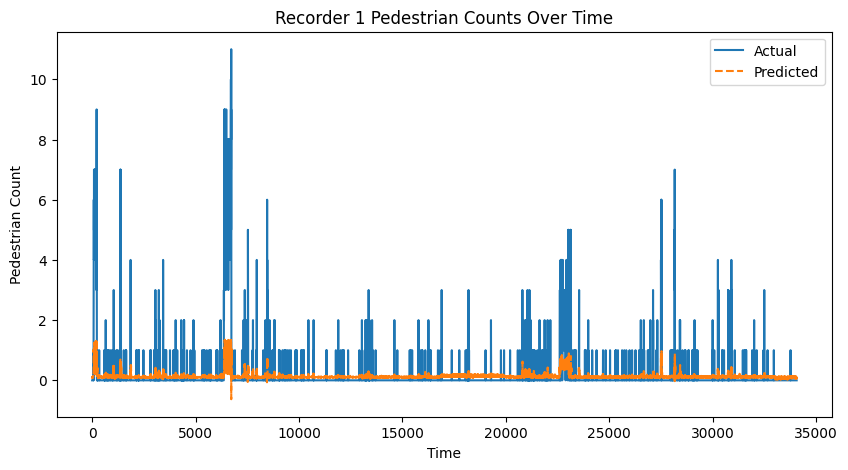

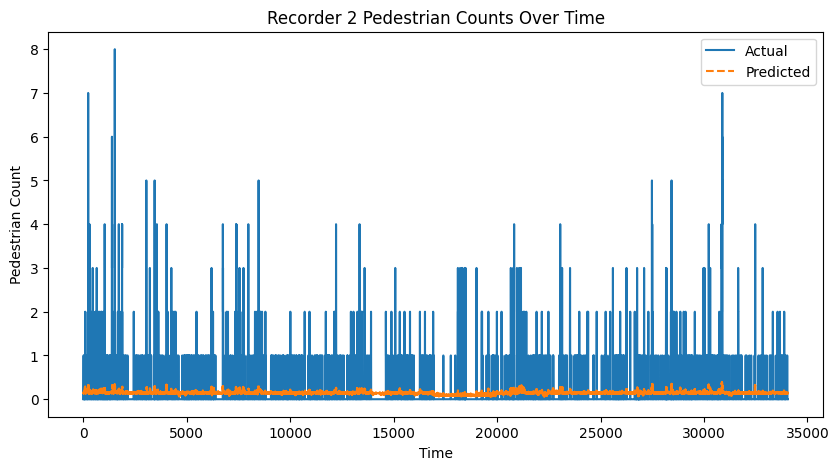

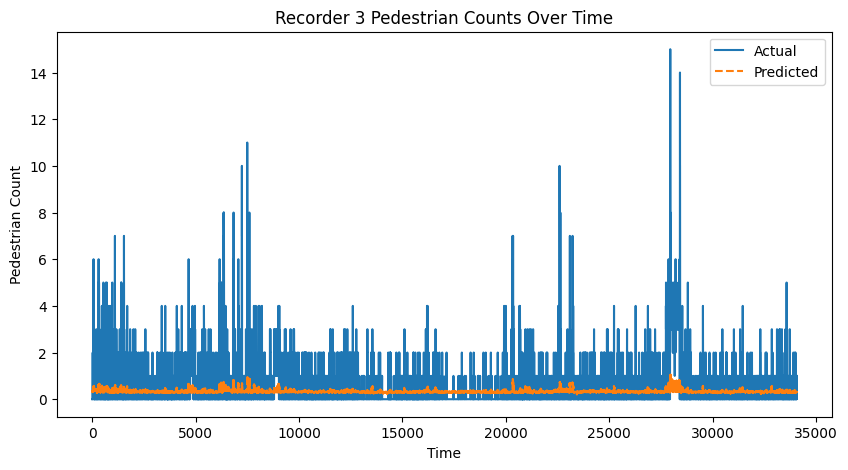

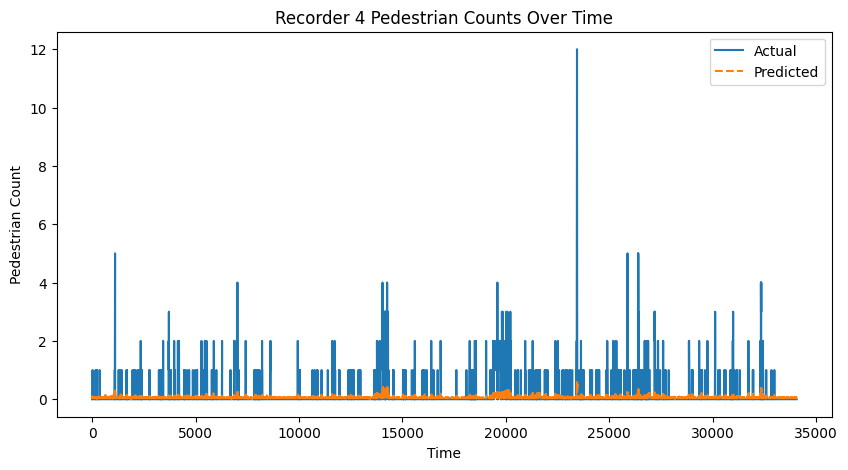

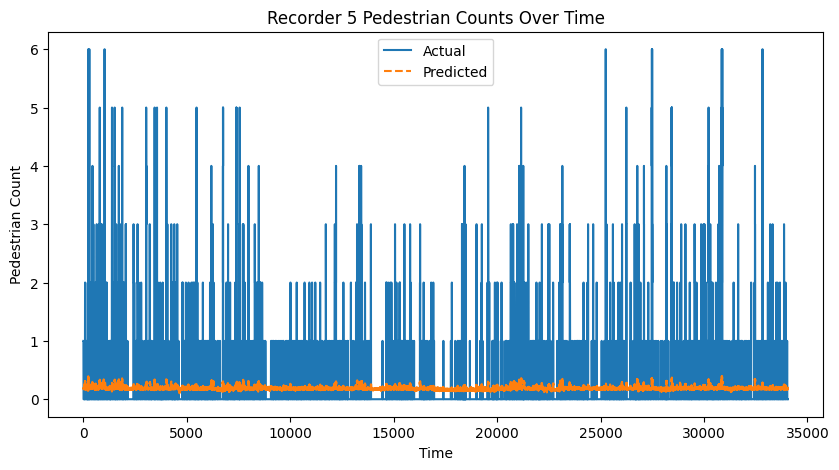

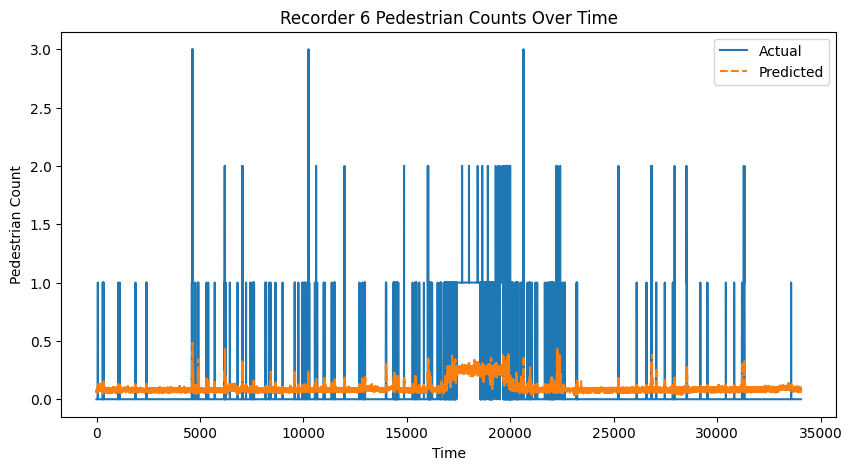

In [38]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Reverse scaling for both predictions and actual targets
actual_counts = reverse_min_max_scale(test_targets.numpy(), targets_min, targets_max)
predicted_counts = reverse_min_max_scale(predictions.numpy(), targets_min, targets_max)

# Plot actual vs. predicted for each recorder
for i in range(6):  # Assuming there are 6 recorders
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(actual_counts)), actual_counts[:, i], label='Actual')
    plt.plot(range(len(actual_counts)), predicted_counts[:, i], label='Predicted', linestyle='--')
    # plt.bar(range(data['timestamp'].index.size), actual_counts[:, i], label='Actual', width=1)
    # plt.xlim([data['timestamp'].min(), data['timestamp'].max()])

    plt.title(f'Recorder {i+1} Pedestrian Counts Over Time')
    plt.xlabel('Time')
    plt.ylabel('Pedestrian Count')
    
    plt.legend()
    plt.show()


In [614]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Assuming 'timestamps' is a datetime array and 'actual_counts', 'predicted_counts' are arrays of your data.
# Filter the data first to remove 7 PM to 7 AM if not already removed
data = pd.DataFrame({
    'timestamp': timestamps,
    'actual': actual_counts[:,1],
    'predicted': predicted_counts[:,1]
})
data['hour'] = data['timestamp'].dt.hour
data = data[(data['hour'] >= 7) & (data['hour'] < 19)]

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data['timestamp'], data['actual'], label='Actual', linewidth=2)
ax.plot(data['timestamp'], data['predicted'], label='Predicted', linestyle='--')

# Formatting the plot
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set major ticks to hourly interval
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H-%M'))  # Format date

# Rotate date labels for better readability
plt.xticks(rotation=45)
plt.title('Recorder 1 Pedestrian Counts Over Time')
plt.xlabel('Time')
plt.ylabel('Pedestrian Count')
plt.legend()
plt.tight_layout()

# Show only day hours
plt.xlim([data['timestamp'].min(), data['timestamp'].max()])

plt.show()


ValueError: All arrays must be of the same length